In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier # horrible because inbalanced classes
from sklearn.linear_model import LogisticRegression # sucks
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import NuSVC
from sklearn.svm import SVC
import shlex
import subprocess
import sys
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, TorsionFingerprints
from rdkit.Chem import Descriptors
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem.AtomPairs import Torsions
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import Draw
from multiprocessing import Pool
import math
import timeit
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from e3fp.fingerprint.generate import fp, fprints_dict_from_mol
# from e3fp.conformers.generate import generate_conformers
from e3fp.pipeline import fprints_from_smiles
import cirpy
%run MontyCarlo.ipynb
import random
random.seed(0)

In [29]:
x=AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O"),2,useChirality=True)
y=AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("OC[C@H]1[C@H](O)[C@@H](O)[C@H](O)C(O)O1"),2,useChirality=True)
print(x==y)
x=AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O"),2)
y=AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("OC[C@H]1[C@H](O)[C@@H](O)[C@H](O)C(O)O1"),2)
print(x==y)
x=pyAvalonTools.GetAvalonFP(Chem.MolFromSmiles("C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O"))
y=pyAvalonTools.GetAvalonFP(Chem.MolFromSmiles("OC[C@H]1[C@H](O)[C@@H](O)[C@H](O)C(O)O1"))
print(x==y)
x=SimilarityMaps.GetRDKFingerprint(Chem.MolFromSmiles("C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O"))
y=SimilarityMaps.GetRDKFingerprint(Chem.MolFromSmiles("OC[C@H]1[C@H](O)[C@@H](O)[C@H](O)C(O)O1"))
print(x==y)

x = fprints_from_smiles("C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O",'a')
y = fprints_from_smiles("OC[C@H]1[C@H](O)[C@@H](O)[C@H](O)C(O)O1",'a')
# print(sorted(x[0].indices))
a = sorted([sorted(i.indices) for i in x])
b = sorted([sorted(i.indices) for i in y])
x = set([tuple(np.array(i.fold().to_rdkit())) for i in x])
y = set([tuple(np.array(i.fold().to_rdkit())) for i in y])
print(x == y)
print(a == b)


2022-02-18 16:17:25,904|INFO|Generating conformers for a.


False
True
True
True


2022-02-18 16:17:26,893|INFO|Generated 15 conformers for a.
2022-02-18 16:17:26,894|INFO|Generating fingerprints for a.
2022-02-18 16:17:27,045|INFO|Generated 3 fingerprints for a.
2022-02-18 16:17:27,046|INFO|Generating conformers for a.
2022-02-18 16:17:27,803|INFO|Generated 16 conformers for a.
2022-02-18 16:17:27,804|INFO|Generating fingerprints for a.
2022-02-18 16:17:27,932|INFO|Generated 3 fingerprints for a.


False
False


In [18]:
df = pd.read_excel('SixC-Ring SMILES final chemical library v2.xlsx')
# df = pd.read_excel('SMILES final chemical library.xlsx')
df.drop(columns=df.columns[3:],inplace=True)
df.columns = ['smiles', 'names', 'label']
df['label'] = [i[0] == 'a' for i in df['label']]


bits = int(2048)

smiles = df['smiles']
names = df['names']
molecs = [Chem.MolFromSmiles(i) for i in smiles]
[i.SetProp("_Name",j) for i,j in zip(molecs,names)]
molecs = [i for i in molecs if not i == None]
fingerprint = np.array([AllChem.GetMorganFingerprintAsBitVect(i,2,useChirality=True,nBits=bits) for i in molecs])


label = df['label']
tot = len(label)
pos = sum(label)
neg = tot - sum(label)




# print(df)
print(f"FULL Dataset: {df.shape}")
print("Fingerprint:",fingerprint.shape,"Sparcity:",np.mean(fingerprint))


FULL Dataset: (173, 3)
Fingerprint: (173, 2048) Sparcity: 0.012085666546242775


# Model Choice

In [32]:

trialsp = 1
trialsn = 1

print('SGD')

individual = lambda: make_pipeline(
    PCA(n_components=1024),
    SGDClassifier(loss='log', penalty='elasticnet', validation_fraction=sys.float_info.min,n_jobs=-1)
)
# individual = lambda: SGDClassifier(loss='log', penalty='elasticnet', validation_fraction=sys.float_info.min,n_jobs=-1)
getmodel = lambda: VotingClassifier( [(str(i),individual()) for i in range(10)], voting= 'soft', n_jobs=-1)

for _ in range(3):

    def test_model(i):
        short_finger = list(fingerprint[:i%pos]) + list(fingerprint[(i%pos)+1:])
        model = getmodel()
        model.fit(short_finger,label[1:])
        return model.score([fingerprint[i%pos]],[1])/trialsp/pos
    correct1 = sum(map(test_model,range(trialsp*pos)))
#     print(f"model acccuracy for posatives: {correct1}")
    def test_model(i):
        short_finger = list(fingerprint[:pos+(i%neg)]) + list(fingerprint[pos+1+(i%neg):])
        model = getmodel()
        model.fit(short_finger,label[:-1])
        return model.score([fingerprint[pos+(i%neg)]],[0])/trialsn/neg
    correct0 = sum(map(test_model,range(trialsn*neg)))
#     print(f"model acccuracy for negatives: {correct0}")
    ppv = correct1*pos/(correct1*pos+(1-correct0)*neg)
#     print(f"P(1 | predict 1) = P(predict 1 | 1) P(1) / P(predict 1) = {ppv}")
    print(f"#  {len(fingerprint[0])}: ({round(correct1,2)}, {round(correct0,2)}, {round(ppv,2)})")



# T 2048:
#  2048: (0.26, 0.96, 0.27)
#  2048: (0.22, 0.96, 0.25)
#  2048: (0.24, 0.96, 0.27)
#  2048: (0.24, 0.96, 0.26)
#  2048: (0.22, 0.96, 0.26)
#  2048: (0.27, 0.96, 0.31)
#  2048: (0.26, 0.96, 0.3)
#  2048: (0.22, 0.95, 0.22)
#  2048: (0.23, 0.96, 0.27)
#  2048: (0.24, 0.95, 0.23)

# E 4096:
#  4096: (0.03, 0.99, 0.21)
#  4096: (0.03, 1.0, 0.27)
#  4096: (0.07, 1.0, 0.5)
#  4096: (0.03, 1.0, 0.27)
#  4096: (0.05, 1.0, 0.42)
#  4096: (0.04, 1.0, 0.67)
#  4096: (0.05, 1.0, 0.42)
#  4096: (0.04, 1.0, 0.4)
#  4096: (0.07, 1.0, 0.64)
#  4096: (0.05, 1.0, 0.5)

# chiral M 2048:
#  2048: (0.15, 0.99, 0.62)
#  2048: (0.09, 0.99, 0.45)
#  2048: (0.14, 0.99, 0.58)
#  2048: (0.16, 0.99, 0.62)
#  2048: (0.17, 0.99, 0.49)
#  2048: (0.12, 0.99, 0.55)
#  2048: (0.16, 0.99, 0.62)
#  2048: (0.12, 0.99, 0.44)
#  2048: (0.14, 0.99, 0.61)
#  2048: (0.1, 0.99, 0.43)

# chiral M 2048 -> 50 PCA:
#  2048: (0.07, 0.98, 0.21)
#  2048: (0.08, 0.99, 0.25)
#  2048: (0.09, 0.99, 0.3)
#  2048: (0.1, 0.99, 0.38)
#  2048: (0.09, 0.98, 0.24)
#  2048: (0.1, 0.99, 0.31)
#  2048: (0.06, 0.99, 0.21)
#  2048: (0.09, 0.99, 0.29)
#  2048: (0.09, 0.99, 0.29)
#  2048: (0.11, 0.99, 0.38)



# chiral M 2048 with 10 member Voting comittee:
#  2048: (0.15, 1.0, 1.0)
#  2048: (0.15, 1.0, 1.0)
#  2048: (0.15, 1.0, 1.0)
#  2048: (0.15, 1.0, 1.0)
#  2048: (0.17, 1.0, 1.0)
#  2048: (0.17, 1.0, 1.0)

# chiral M 1024 with 10 member Voting comittee:
#  1024: (0.19, 1.0, 0.95)
#  1024: (0.19, 1.0, 1.0)
#  1024: (0.19, 1.0, 1.0)

# chiral M 128 with 10 member Voting comittee:
#  128: (0.04, 0.98, 0.12)
#  128: (0.05, 0.98, 0.15)
#  128: (0.05, 0.98, 0.16)




print('done!')

SGD


In [ ]:
model_generator = lambda: make_pipeline(
#     PCA(n_components=50),
    SGDClassifier(loss='log', penalty='elasticnet', validation_fraction=sys.float_info.min,n_jobs=-1)
)

measurements = 10

means = []
stds = []
truths = []
for test in range(len(label)):
    testfp = fingerprint[test,:]
    truth = label[test]
    trainfp = np.array([i for e,i in enumerate(fingerprint) if e != test])
    trainlab = np.array([i for e,i in enumerate(label) if e != test])
    print(test,'/',len(label),'Leaving out: ',names[test],'=',label[test])
    print('Training on',fingerprint.shape,'data')
    chemscore = []
    for _ in range(measurements):
        model = model_generator()
        model.fit(trainfp,trainlab)


        prediction = model.predict_proba([testfp])[0][1]
        chemscore.append(prediction)
    means.append(np.mean(chemscore))
    stds.append(np.std(chemscore))
    truths.append(truth)
    print('Mean Error:',round(label[test] - np.mean(chemscore),4),'Std:',round(np.std(chemscore),3))
print('Done!')

0 / 173 Leaving out:  Meglumine = True
Training on (173, 2048) data
Mean Error: 1.0 Std: 0.0
1 / 173 Leaving out:  D-(+)-Mannose = True
Training on (173, 2048) data
Mean Error: 0.9996 Std: 0.001
2 / 173 Leaving out:  sn-Glycerol 3-phosphate bis(cyclohexylammonium) salt = True
Training on (173, 2048) data
Mean Error: 1.0 Std: 0.0
3 / 173 Leaving out:  1-Deoxy-1-morpholino-D-fructose = True
Training on (173, 2048) data
Mean Error: 0.6129 Std: 0.475
4 / 173 Leaving out:  D-Fructose 6-phosphate dipotassium salt = True
Training on (173, 2048) data
Mean Error: 1.0 Std: 0.0
5 / 173 Leaving out:  D-(-)-Fructose = True
Training on (173, 2048) data
Mean Error: 0.4272 Std: 0.468
6 / 173 Leaving out:  D-(+)-Turanose = True
Training on (173, 2048) data
Mean Error: 1.0 Std: 0.0
7 / 173 Leaving out:  D-(+)-Glucose = True
Training on (173, 2048) data
Mean Error: 0.9003 Std: 0.288
8 / 173 Leaving out:  D-Glucamine = True
Training on (173, 2048) data
Mean Error: 0.9962 Std: 0.012
9 / 173 Leaving out:  2

Mean Error: -0.0 Std: 0.0
74 / 173 Leaving out:  Chloralose = False
Training on (173, 2048) data
Mean Error: -0.0 Std: 0.0
75 / 173 Leaving out:  p-Acetamidophenyl beta-D-glucuronide sodium salt = False
Training on (173, 2048) data
Mean Error: -0.0 Std: 0.0
76 / 173 Leaving out:  Arbutin = False
Training on (173, 2048) data
Mean Error: -0.0 Std: 0.0
77 / 173 Leaving out:  D-Sorbitol = False
Training on (173, 2048) data
Mean Error: -0.0529 Std: 0.158
78 / 173 Leaving out:  2'-Hydroxy-4'-methoxyacetophenone = False
Training on (173, 2048) data
Mean Error: -0.0 Std: 0.0
79 / 173 Leaving out:  D-Mannitol = False
Training on (173, 2048) data
Mean Error: -0.0478 Std: 0.094
80 / 173 Leaving out:  D-Mannose 6-phosphate disodium salt hydrate = False
Training on (173, 2048) data
Mean Error: -0.0897 Std: 0.269
81 / 173 Leaving out:  D-Fructose 1,6-bisphosphate trisodium salt hydrate = False
Training on (173, 2048) data
Mean Error: -0.0 Std: 0.0
82 / 173 Leaving out:  6-deoxy-l-galactonic acid sod

Mean Error: -0.0 Std: 0.0
148 / 173 Leaving out:  Aucubin = False
Training on (173, 2048) data
Mean Error: -0.0 Std: 0.0
149 / 173 Leaving out:  N-Acetyl-D-lactosamine = False
Training on (173, 2048) data
Mean Error: -0.0 Std: 0.0
150 / 173 Leaving out:  Decyl beta-D-glucopyranoside = False
Training on (173, 2048) data
Mean Error: -0.0 Std: 0.0
151 / 173 Leaving out:  L(+)-Erythrose = False
Training on (173, 2048) data
Mean Error: -0.0 Std: 0.0
152 / 173 Leaving out:  D-(+)-Galactosamine hydrochloride = False
Training on (173, 2048) data
Mean Error: -0.0 Std: 0.0
153 / 173 Leaving out:  IPTG = False
Training on (173, 2048) data
Mean Error: -0.0 Std: 0.0
154 / 173 Leaving out:  Octyl alpha-D-glucopyranoside = False
Training on (173, 2048) data
Mean Error: -0.0 Std: 0.0
155 / 173 Leaving out:  L-(+)-Ribose = False
Training on (173, 2048) data
Mean Error: -0.0 Std: 0.0
156 / 173 Leaving out:  Gastrodin = False
Training on (173, 2048) data
Mean Error: -0.0 Std: 0.0
157 / 173 Leaving out:  

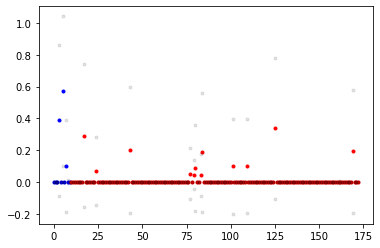

In [ ]:
plt.plot(*zip(*[(x,y) for y,j,x in zip(means,truths,range(len(means))) if j]),'.',color='blue')
plt.plot(*zip(*[(x,m+y) for m,y,j,x in zip(means,stds,truths,range(len(means))) if j]),'.',alpha=0.1,color='black')
plt.plot(*zip(*[(x,m-y) for m,y,j,x in zip(means,stds,truths,range(len(means))) if j]),'.',alpha=0.1,color='black')
plt.plot(*zip(*[(x,y) for y,j,x in zip(means,truths,range(len(means))) if not j]),'.',color='red')
plt.plot(*zip(*[(x,m+y) for m,y,j,x in zip(means,stds,truths,range(len(means))) if not j]),'.',alpha=0.1,color='black')
plt.plot(*zip(*[(x,m-y) for m,y,j,x in zip(means,stds,truths,range(len(means))) if not j]),'.',alpha=0.1,color='black')
plt.show()

(173, 2048)


Text(0.5, 1.0, 'UMAP')

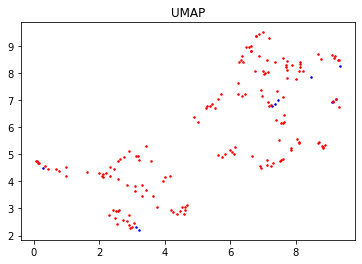

In [ ]:
import umap.umap_ as umap
# import numba

# @numba.njit()
# def tanimoto_d(u, v):
#     return 1 - sum([i*j for i,j in zip(u,v)]) / sum([i+j - i*j for i,j in zip(u,v)])
print(fingerprint.shape)
embedding_umap = umap.UMAP(metric='cosine').fit_transform(PCA(n_components=30).fit_transform(fingerprint))
fig = plt.figure()
ax = plt.axes()
ax.plot(*embedding_umap[:pos].T, "b.", markersize=3)
ax.plot(*embedding_umap[pos:].T, "r.", markersize=3)
ax.set_title('UMAP')


# Log loss unbalanced SGD performed the best.

chiral morgon fingerprint with 2048 bits on an comittee of 10 unbalanced SGD linear classifiers with elasticnet loss

In [ ]:
%run MontyCarlo.ipynb
# successes = 3 close, 5
gone = 1# 1, 5, 7
# gone = smiles.index('')
print(f"{names[gone]}:\t{smiles[gone]}")

individual = lambda x: SGDClassifier(random_state=x,loss='log', penalty='elasticnet', validation_fraction=sys.float_info.min,n_jobs=-1)
getmodel = lambda: VotingClassifier([(str(i),individual(i)) for i in range(10)], voting= 'soft', n_jobs=-1)

short_finger = list(fingerprint[:gone]) + list(fingerprint[gone+1:])
short_label = list(label[:gone]) + list(label[gone+1:])
model = getmodel()
print("model ready!")
model.fit(short_finger,short_label)

# models = [(str(i),SGDClassifier(random_state=i,loss='log', validation_fraction=sys.float_info.min, penalty='elasticnet')) for i in range(10)]
# model = VotingClassifier(models, voting= 'soft', n_jobs=-1)
# # model = SGDClassifier(random_state=0,loss='log', validation_fraction=sys.float_info.min, penalty='elasticnet',n_jobs=-1)
# model.fit(short_finger,[i for i in label if i != gone])
print("fit model!")

creativity = 0
def model_on_list(x):
    result = []
    for s in x:
        fingerprint = np.array([AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s),2,useChirality=True,nBits=bits)])
        result.append(model.predict_proba(fingerprint)[0][1]*(1-creativity)+0.5*creativity)
    return result
pred = (model_on_list([smiles[gone]])[0] -0.5*creativity)/(1-creativity)
print(f"prediction: {round(pred,2)}")

pcut = 0.5
rollouts = 1000
if pred < pcut:
    print("WARNING: FULL MOLECULE PREDICTED NOT TO BIND\n\tSCORE\t= ",round(pred,2))
    
print("running monty carlo search...")
min_molecule = mcts(
    smiles[gone],
    model_on_list,
    rollouts, # number of rollouts
    pcut, # probability cutoff
)

template = Chem.MolFromSmiles(smiles[gone])
AllChem.Compute2DCoords(template)
for i,n in enumerate(min_molecule):
    print(f"Submolecule {i}:\tScore = {round(n[0],2)}\t{n[1]}")
mMols = [Chem.MolFromSmiles(smiles[gone])] + [Chem.MolFromSmiles(m[1]) for m in min_molecule]

if pred < pcut:
    print("WARNING: FULL MOLECULE PREDICTED NOT TO BIND\n\tSCORE = ",round(pred,2))
    
print('Done!')

D-(+)-Mannose:	O[C@H]1[C@H](O)[C@H](O)C(O)O[C@@H]1CO
model ready!
fit model!
prediction: 0.0
	SCORE	=  0.0
running monty carlo search...
Submolecule 0:	Score = 0.71	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 1:	Score = 0.71	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 2:	Score = 0.71	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 3:	Score = 0.71	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 4:	Score = 0.71	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 5:	Score = 0.71	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 6:	Score = 0.71	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 7:	Score = 0.71	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 8:	Score = 0.71	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 9:	Score = 0.71	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 10:	Score = 0.71	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 11:	Score = 0.71	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 12:	Score = 0.71	OC[C@H]1OC(O)[CH2:1][CH2:1][C@@H]1O
Submolecule 13:	Score = 0.71

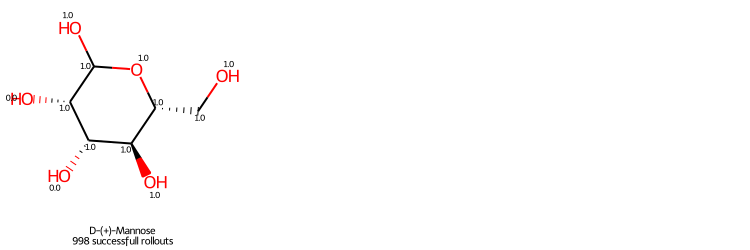

In [ ]:
# Draw.MolsToGridImage(mMols,legends=[names[gone] + f': {rollouts} rollouts']+[f'Submolecule {i}' for i,j in enumerate(min_molecule)], subImgSize=(250,250), useSVG=False)

fragments = [mMols[0].GetSubstructMatch(m) for m in mMols[1:]]
for at in mMols[0].GetAtoms():
    overlaps = [at.GetIdx() in f for f in fragments]
    at.SetProp('atomNote',f"{round(sum(overlaps)/len(overlaps),2)}")
    
main_mol = mMols[0]
# print(f"{smiles[gone]}")
# print(f"{names[gone]}")
# print(f"{len(fragments)} rollouts")
# Draw.MolsToGridImage(mMols,legends=[names[gone]]+[f'Submolecule {i+1}/{len(fragments)}' for i in range(len(mMols)-1)], subImgSize=(250,250), useSVG=False)
Draw.MolsToGridImage(mMols[:1],legends=[names[gone]+f"\n{len(fragments)} successfull rollouts"], subImgSize=(250,250), useSVG=False)
# main_mol

# Scoring the catalog

Training model!
Model trained!
Largest error on training data: 0.0030397327956983577


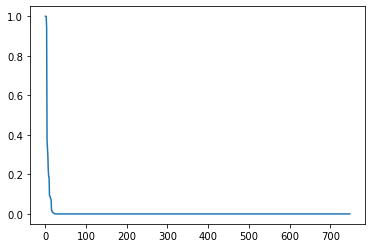

In [19]:
models = [(str(i),SGDClassifier(random_state=i,loss='log', validation_fraction=sys.float_info.min, penalty='elasticnet')) for i in range(100)]
model = VotingClassifier(models, voting= 'soft',n_jobs=-1)
print('Training model!')
model.fit(fingerprint,label)
print('Model trained!')
df = pd.read_excel('StockListCarbohydratesFiltered.xlsx')
# print(df)
def run_on_one(s):
    s = Chem.MolFromSmiles(s)
    if s == None:
        return 0
    else:
        return model.predict_proba([AllChem.GetMorganFingerprintAsBitVect(s,2,useChirality=True,nBits=bits)])[0][1]
def model_on_list(x):
    pool = Pool(16)
    result = list(pool.map(run_on_one,x))
    pool.close()
    pool.join()
    return result

train_reslt = model_on_list(smiles)
predictions = np.array(train_reslt) - np.array(label)
print('Largest error on training data:',max(abs(predictions)))


inp = list(df['SMILES'])
predictions = list(zip(model_on_list(inp),df['Name'],df['SMILES']))
predictions.sort(reverse=True)

plt.plot([i[0] for i in predictions])
plt.show()

hits: 4
C1[C@H]([C@H]([C@@H](C(O1)(CO)O)O[C@@H]2[C@@H]([C@H]([C@@H]([C@H](O2)CO)O)O)O)O)O
CNC[C@@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O
C([C@@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)N
CNC[C@@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O.Cl


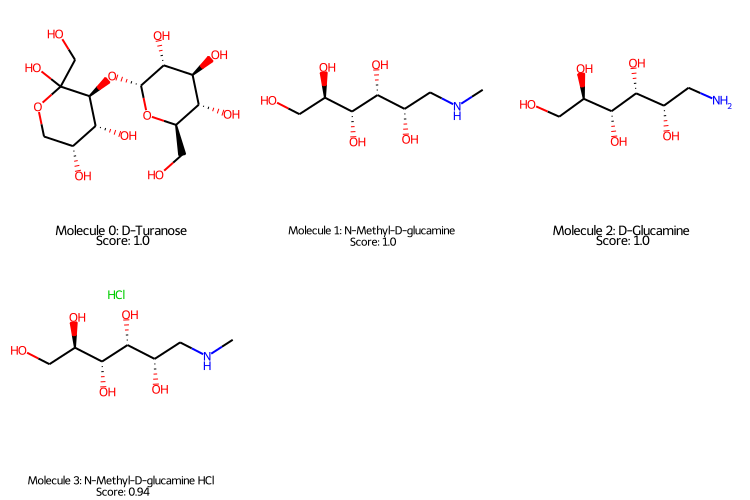

In [20]:
posatives = [i for i in predictions if i[0] > 0.5]
print(f"hits: {len(posatives)}")
print('\n'.join([i[2] for i in posatives]))


mMols = [Chem.MolFromSmiles(m[2]) for m in posatives]
Draw.MolsToGridImage(mMols,legends=[f'Molecule {x}: {i[1]}\nScore: {round(i[0],2)}' + (i[2] in smiles)*'\nin training' for x,i in enumerate(posatives)], subImgSize=(250,250), useSVG=False)


(0.9997565818869137, 'D-Turanose', 'C1[C@H]([C@H]([C@@H](C(O1)(CO)O)O[C@@H]2[C@@H]([C@H]([C@@H]([C@H](O2)CO)O)O)O)O)O')
Max of 276.0 scorings per rollout
Submolecule 0:	OC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@H](O)COC2(O)[CH3:1])[C@H](O)[C@@H](O)[C@@H]1O
Submolecule 1:	OC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@H](O)COC2(O)CO)[C@H](O)[CH2:1][C@@H]1O
Submolecule 2:	OC[C@H]1O[C@H](O[C@H]2[C@H](O)[CH2:1]COC2(O)CO)[C@H](O)[C@@H](O)[C@@H]1O
Submolecule 3:	OC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@H](O)COC2(O)CO)[CH2:1][C@@H](O)[C@@H]1O
Submolecule 4:	OC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@H](O)COC2(O)CO)[CH2:1][CH2:1][C@@H]1O
Submolecule 5:	OC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@H](O)COC2(O)[CH3:1])[C@H](O)[C@@H](O)[C@@H]1O
Submolecule 6:	OC[C@H]1O[C@H](O[C@H]2[C@H](O)[CH2:1]COC2(O)CO)[CH2:1][CH2:1][C@@H]1O
Submolecule 7:	OC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@H](O)COC2(O)CO)[CH2:1][CH2:1][CH2:1]1
Submolecule 8:	OC[C@H]1O[C@H](O[C@H]2[C@H](O)[CH2:1]COC2(O)CO)[CH2:1][CH2:1][C@@H]1O
Submolecule 9:	OC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@H](O)

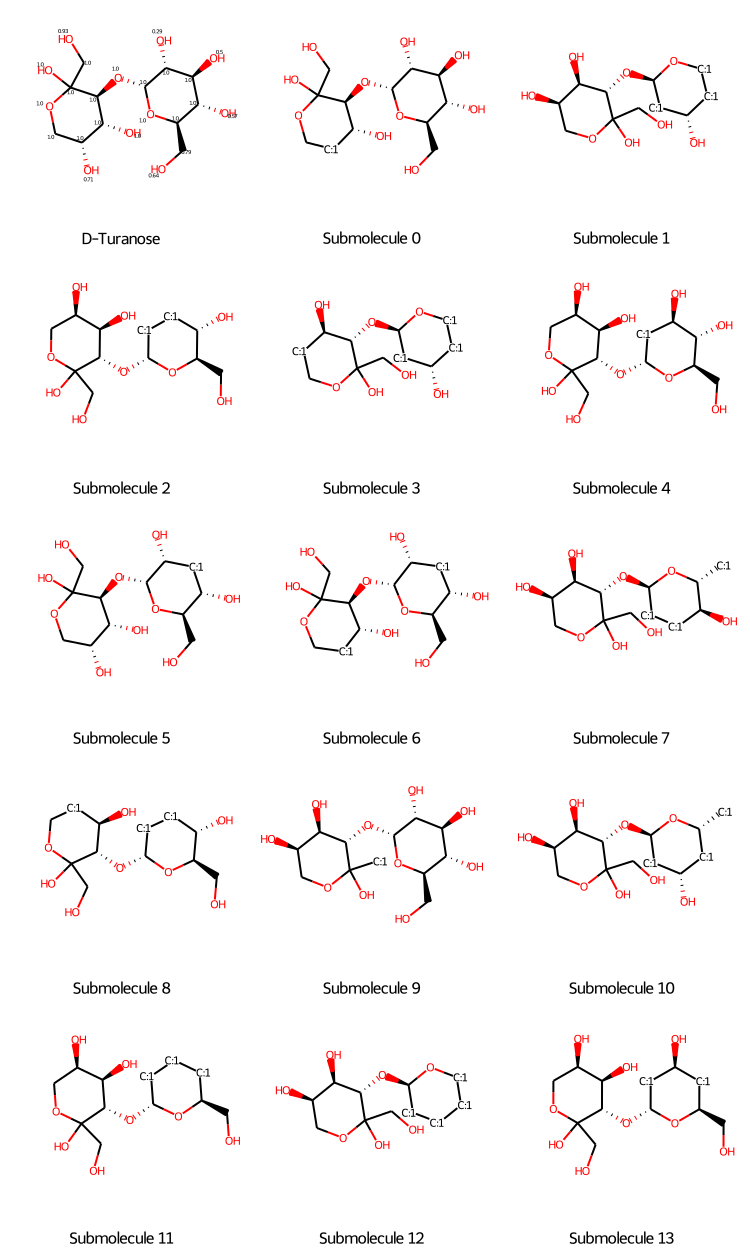

In [23]:
checking = posatives[0]
# smiles = "O[C@H]1[C@@H](C(COP([O-])([O-])=O)(O[C@@H]1COP([O-])([O-])=O)O)O"
# smiles = "O[C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)CNCCCCCCCCCCCCCCCCCC"
# checking = [run_on_one(smiles),'Weird Molecule',smiles] # use this instead of 6
print(checking)
# like 10 hrs for rolling out just 31 (level 0) for posative 6
source = Chem.MolFromSmiles(checking[2])
print(f"Max of {len(source.GetBonds())*(len(source.GetBonds())-1)/2} scorings per rollout")

rollouts = 100
min_molecule = mcts(
    checking[2],
    model_on_list,
    rollouts, # number of rollouts
    0.5, # probability cutoff
)

for i,n in enumerate(min_molecule):
    print(f"Submolecule {i}:\t{n[1]}")
min_smiles = set([i[1] for i in min_molecule])
mMols = [Chem.MolFromSmiles(checking[2])] + [Chem.MolFromSmiles(m) for m in min_smiles]

sub_mols = [Chem.MolFragmentToSmiles(mMols[0], mMols[0].GetSubstructMatch(m)) for m in mMols[1:]]
# print(sub_mols)
# print([m[1] for m in min_molecule])


fragments = [mMols[0].GetSubstructMatch(m) for m in mMols[1:]]
for at in mMols[0].GetAtoms():
    overlaps = [at.GetIdx() in f for f in fragments]
    at.SetProp('atomNote',f"{round(np.mean(overlaps),2)}")
    

Draw.MolsToGridImage(mMols,legends=[f'{checking[1]}']+[f'Submolecule {i}' for i in range(len(mMols)-1)], subImgSize=(250,250), useSVG=False)


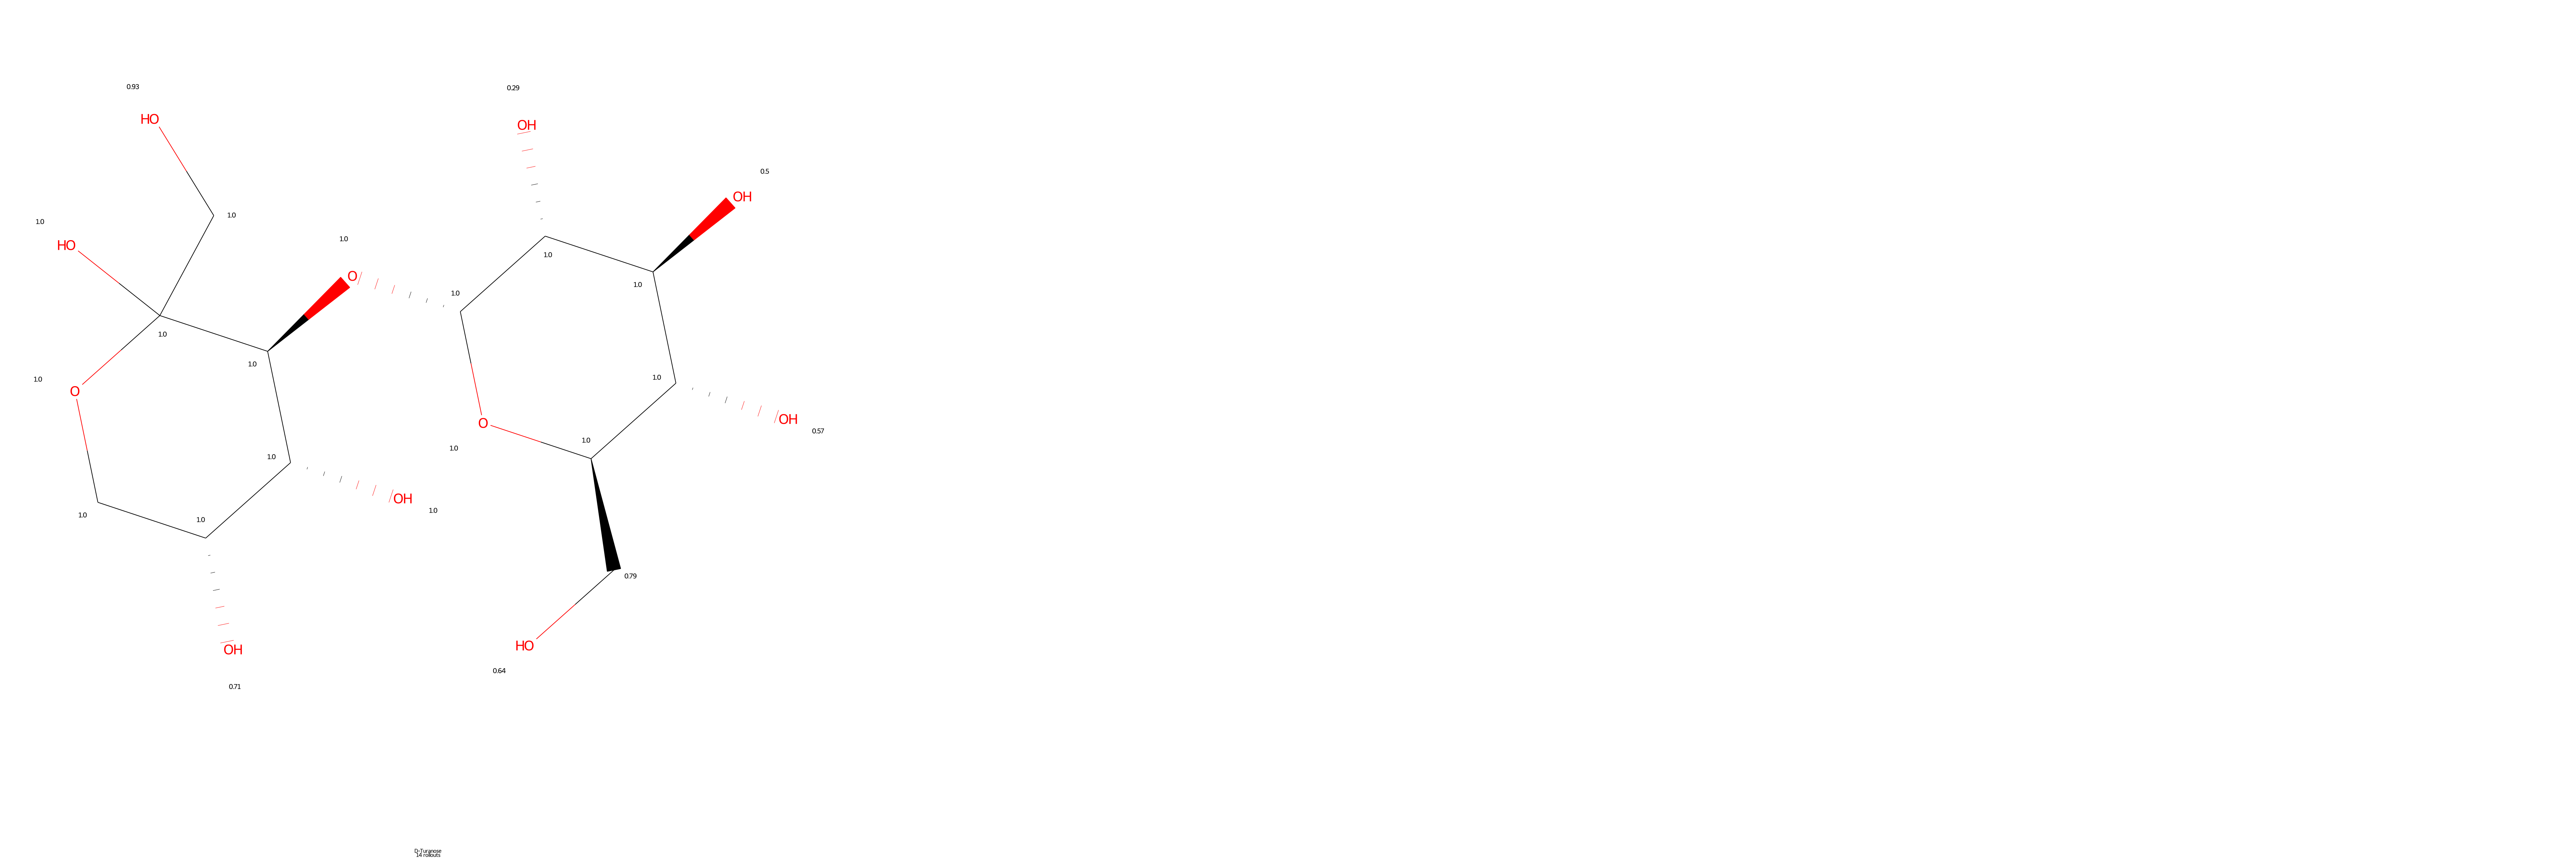

In [25]:
Draw.MolsToGridImage(mMols[:1],legends=[checking[1]+f"\n{len(fragments)} rollouts"], subImgSize=(2500,2500), useSVG=False)
